In [2]:
# append parent directory to path for jupyter
import sys
sys.path.insert(1,"../")

from src.load_datasets import get_mnist_loader, get_fmnist_loader
from src.utils import seed_everything, load_config

In [3]:
from pprint import pp

yaml_path = '../configs/notebook_config.yml'
config = load_config(yaml_path)

pp(config)

{'seed': 0,
 'dataset': 'mnist',
 'data_dir': '../data',
 'device': 'cuda:0',
 'batch_size': 1024,
 'learning_rate': 0.01,
 'weight_decay': 0.01,
 'max_lr': 0.001,
 'train_epochs': 10,
 'warmup_epochs': 5,
 'img_height': 28,
 'img_width': 28,
 'hidden_dim': 64,
 'latent_dim': 8,
 'n_layers': 3,
 'layernorm': True}


In [4]:
# set random seeds
seed_everything(config["seed"])

In [5]:
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [6]:
logger.info(f"Loading {config['dataset']} dataset with batch size {config['batch_size']}")

if config['dataset'] == "mnist":
    trainloader, testloader = get_mnist_loader(config['data_dir'], batch_size=config['batch_size'])
elif config['dataset'] == "fmnist":
    trainloader, testloader = get_fmnist_loader(config['data_dir'], batch_size=config['batch_size'])
else:
    logger.error(f"Dataset must be either 'mnist' or 'fmnist' ")

2024-10-01 02:48:18,557 - INFO - Loading mnist dataset with batch size 1024


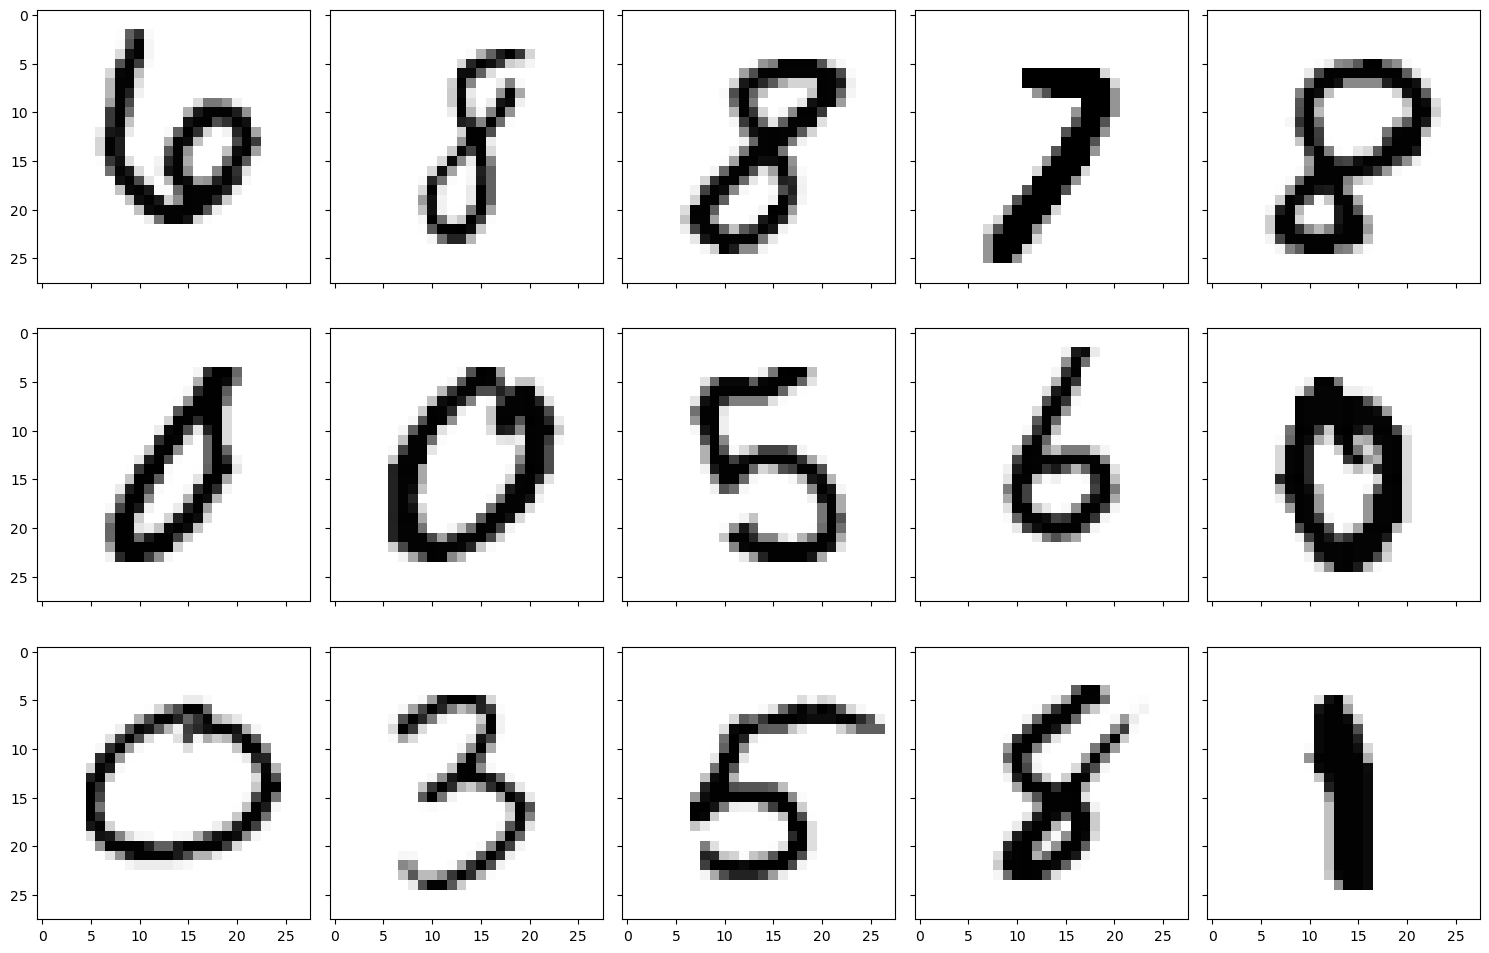

In [7]:
import matplotlib.pyplot as plt

# visualize data from trainloader
x, y = next(iter(trainloader))

fig, axs = plt.subplots(3, 5, figsize=(15,10), sharex=True, sharey=True)
axs = axs.flatten()
for ax, i in zip(axs, x):
    ax.imshow(i.permute(1,2,0), cmap="Greys")

plt.tight_layout()
plt.show()

In [8]:
from src.train import Trainer
import torch
from src.models import Autoencoder

model = Autoencoder(config['img_height'], 
                    config['img_width'], 
                    config['hidden_dim'], 
                    config['latent_dim'], 
                    config['n_layers'], 
                    layernorm=config['layernorm'])
model = model.to(config['device'])

trainer = Trainer(model, trainloader, testloader, logger)
results = trainer.train(learning_rate=config['learning_rate'], 
                        weight_decay=config['weight_decay'], 
                        warmup_epochs=config['warmup_epochs'], 
                        max_lr=config['max_lr'], 
                        train_epochs=config['train_epochs'], 
                        device=config['device'])


2024-10-01 02:48:21,570 - INFO - Setting up Optimizer and Scheduler
2024-10-01 02:48:29,286 - INFO - epoch: 0	Train loss: 0.000510	Val loss: 0.000361	learning rate: 0.000345
2024-10-01 02:48:36,924 - INFO - epoch: 1	Train loss: 0.000332	Val loss: 0.000324	learning rate: 0.000655
2024-10-01 02:48:44,829 - INFO - epoch: 2	Train loss: 0.000312	Val loss: 0.000312	learning rate: 0.000905
2024-10-01 02:48:52,290 - INFO - epoch: 3	Train loss: 0.000301	Val loss: 0.000303	learning rate: 0.001000
2024-10-01 02:48:59,692 - INFO - epoch: 4	Train loss: 0.000291	Val loss: 0.000291	learning rate: 0.000905
2024-10-01 02:49:07,224 - INFO - epoch: 5	Train loss: 0.000281	Val loss: 0.000282	learning rate: 0.000655
2024-10-01 02:49:14,768 - INFO - epoch: 6	Train loss: 0.000273	Val loss: 0.000276	learning rate: 0.000345
2024-10-01 02:49:22,276 - INFO - epoch: 7	Train loss: 0.000268	Val loss: 0.000270	learning rate: 0.000095
2024-10-01 02:49:29,743 - INFO - epoch: 8	Train loss: 0.000265	Val loss: 0.000270	le

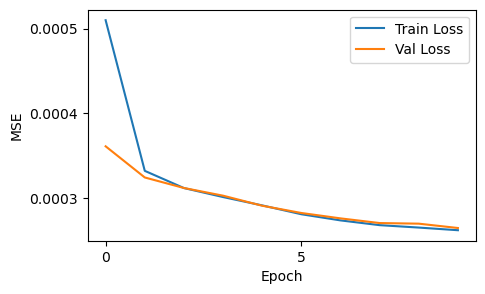

In [9]:
fig, axs = plt.subplots(1,1, figsize=(5,3))
axs.plot(results["train_loss"], label="Train Loss")
axs.plot(results["val_loss"], label="Val Loss")
axs.legend()
axs.set_xlabel("Epoch")
axs.set_ylabel("MSE")
plt.locator_params("y", nbins=2)
plt.locator_params("x", nbins=3)
plt.show()